Import Libaries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns


Load datasets

In [2]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

Pre processing

In [3]:
# Group transactions by CustomerID and aggregate the data
aggregated_transactions = transactions.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    total_transactions=('TransactionID', 'count')
).reset_index()

# Merge the aggregated transactions with the customers dataset
data = pd.merge(customers,
                aggregated_transactions,
                on='CustomerID',
                how='left').fillna(0)


In [4]:

# Display the first few rows of the merged dataset
data.head()

,CustomerID,CustomerName,Region,SignupDate,total_spent,total_transactions
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,5.0
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,4.0
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,4.0
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,8.0
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,3.0


In [5]:
# Encode the 'Region' column using LabelEncoder
label_encoder = LabelEncoder()
data['Region'] = label_encoder.fit_transform(data['Region'])

# Select the features to be scaled
features_to_scale = ['Region', 'total_spent', 'total_transactions']

# Normalize the selected features using StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(data[features_to_scale])


In [6]:
# Display the normalized features
print(features[:5])


[[ 1.24138358 -0.05188436  0.        ]
 [-1.40925752 -0.86271433 -0.45129368]
 [ 1.24138358 -0.393842   -0.45129368]
 [ 1.24138358  1.03537505  1.35388105]
 [-1.40925752 -0.76949861 -0.90258736]]


In [7]:
# Lists to store metric values
db_indexes = []
silhouette_scores = []
calinski_harabasz_scores = []

# Determine optimal number of clusters using different metrics
optimal_k, best_db_index = 2, float('inf')
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(features)
    labels = kmeans.labels_
    
    # Calculate evaluation metrics
    db_index = davies_bouldin_score(features, labels)
    silhouette_avg = silhouette_score(features, labels)
    calinski_harabasz_avg = calinski_harabasz_score(features, labels)
    
    # Append the metric values to the respective lists
    db_indexes.append(db_index)
    silhouette_scores.append(silhouette_avg)
    calinski_harabasz_scores.append(calinski_harabasz_avg)
    
    # Track the optimal k based on the lowest Davies-Bouldin Index
    if db_index < best_db_index:
        best_db_index = db_index
        optimal_k = k

# Print the optimal number of clusters and the corresponding metric values
print(f"Optimal number of clusters: {optimal_k}")
print(f"Davies-Bouldin Index values: {db_indexes}")
print(f"Silhouette Scores: {silhouette_scores}")
print(f"Calinski-Harabasz Scores: {calinski_harabasz_scores}")


Optimal number of clusters: 6
Davies-Bouldin Index values: [np.float64(1.160334171674671), np.float64(1.0413163581042884), np.float64(1.0384493380543123), np.float64(1.0064015606792922), np.float64(0.9524199434948136), np.float64(0.9648731464662964), np.float64(1.105859933848764), np.float64(1.0085585850139145), np.float64(0.9619105656666619)]
Silhouette Scores: [np.float64(0.3301874618092181), np.float64(0.33717725262793263), np.float64(0.3326107363079911), np.float64(0.3130279768181379), np.float64(0.31617630254018686), np.float64(0.30547237823382134), np.float64(0.28263872375047044), np.float64(0.3111693226998635), np.float64(0.3191841932688639)]
Calinski-Harabasz Scores: [np.float64(130.27007573086522), np.float64(124.26607370760259), np.float64(126.8933656783586), np.float64(119.46357220397228), np.float64(123.25422725152569), np.float64(113.02761149337513), np.float64(109.88565223316765), np.float64(114.78885469634695), np.float64(112.41864562820591)]


C:\Users\HARISH\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\HARISH\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^

In [8]:
# Apply KMeans with the optimal number of clusters
data['KMeans_Cluster'] = KMeans(n_clusters=optimal_k, random_state=42).fit_predict(features)

# Apply Agglomerative Clustering with the optimal number of clusters
data['Agglo_Cluster'] = AgglomerativeClustering(n_clusters=optimal_k).fit_predict(features)

# Apply DBSCAN (parameters need to be tuned based on your data)
dbscan = DBSCAN(eps=0.5, min_samples=5)
data['DBSCAN_Cluster'] = dbscan.fit_predict(features)


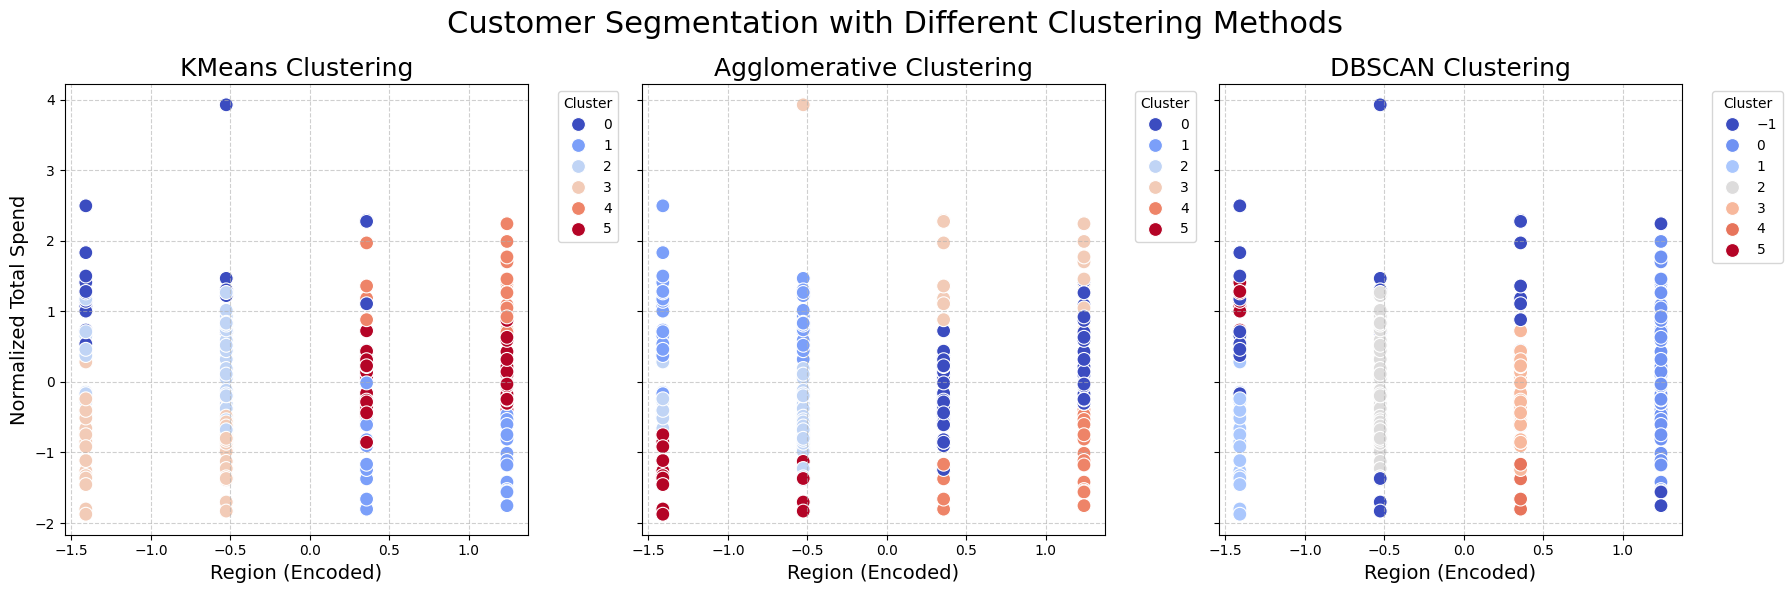

In [9]:
# Enhanced visualization for customer segmentation using different clustering methods
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

clustering_methods = ['KMeans_Cluster', 'Agglo_Cluster', 'DBSCAN_Cluster']
titles = ['KMeans Clustering', 'Agglomerative Clustering', 'DBSCAN Clustering']

for ax, method, title in zip(axes, clustering_methods, titles):
    sns.scatterplot(
        x=features[:, 0], y=features[:, 1], hue=data[method], palette="coolwarm", s=100, edgecolor="white", ax=ax
    )
    ax.set_title(title, fontsize=18)
    ax.set_xlabel("Region (Encoded)", fontsize=14)
    ax.set_ylabel("Normalized Total Spend", fontsize=14)
    ax.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.grid(True, linestyle='--', alpha=0.6)

plt.suptitle(f"Customer Segmentation with Different Clustering Methods", fontsize=22)
plt.tight_layout()
plt.show()


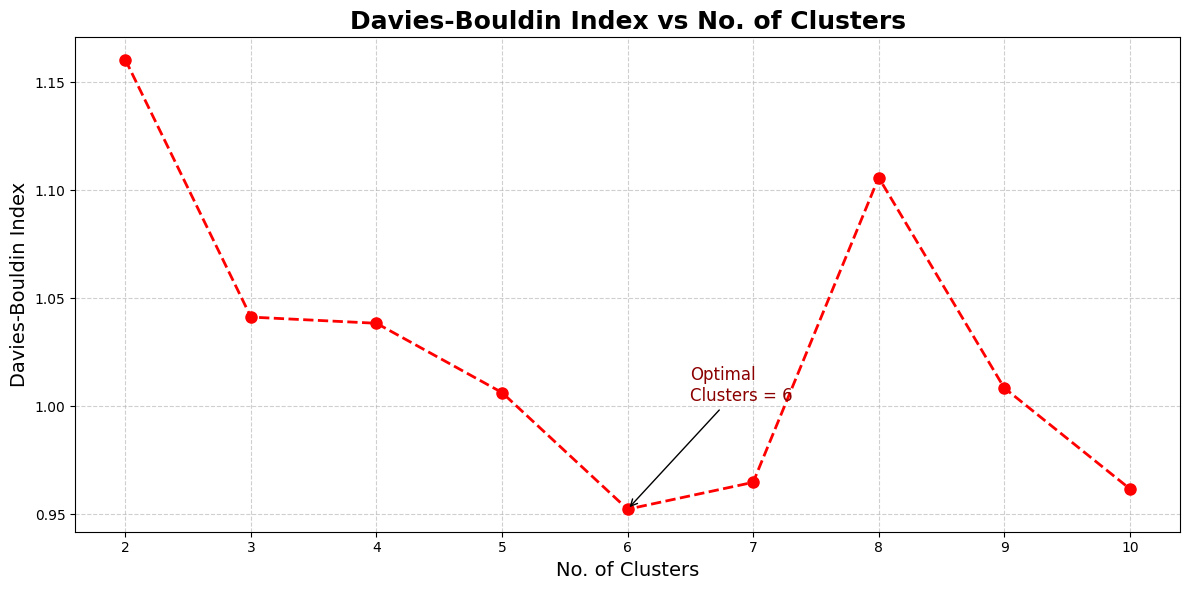

In [10]:

# Visualize DB Index across different cluster counts
plt.figure(figsize=(12, 6))  # Adjusted size for better fit
plt.plot(range(2, 11), db_indexes, marker='o', color='red', linestyle='--', linewidth=2, markersize=8)
plt.title("Davies-Bouldin Index vs No. of Clusters", fontsize=18, weight='bold')
plt.xlabel("No. of Clusters", fontsize=14)
plt.ylabel("Davies-Bouldin Index", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

# Annotate the optimal number of clusters
optimal_idx = db_indexes.index(min(db_indexes))
optimal_clusters = range(2, 11)[optimal_idx]
plt.annotate(f'Optimal\nClusters = {optimal_clusters}', 
             xy=(optimal_clusters, db_indexes[optimal_idx]), 
             xytext=(optimal_clusters + 0.5, db_indexes[optimal_idx] + 0.05),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12, color='darkred')

plt.tight_layout()
plt.show()


In [11]:
# Output results for optimal number of clusters and evaluation metrics
print(f"Optimal Number of Clusters: {optimal_k}")
print(f"Davies-Bouldin Index for Optimal Clusters: {min(db_indexes):.2f}")
print(f"Silhouette Score for Optimal Clusters: {silhouette_scores[optimal_k - 2]:.2f}")
print(f"Calinski-Harabasz Score for Optimal Clusters: {calinski_harabasz_scores[optimal_k - 2]:.2f}")


Optimal Number of Clusters: 6
Davies-Bouldin Index for Optimal Clusters: 0.95
Silhouette Score for Optimal Clusters: 0.32
Calinski-Harabasz Score for Optimal Clusters: 123.25
